In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 5]

import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from geopy import distance

class GPSTreatment:

    def __init__(self, log_num, prefix, meters_en):
        self.label = dict(t=0, lat=1, lon=2, alt=3)
        self.n = log_num
        self.meters_en = meters_en
        self.data = self.load_data(self.n, prefix)
        if meters_en == True:
            sigma = 0.0001
            self.origin = [np.nanmin(self.data[0][:, self.label['lat']]) - sigma, np.nanmin(self.data[0][:, self.label['lon']]) - sigma]
            self.angles_to_meters()

    def load_data(self, n, prefix):
        data = list()
        print('Loading files:')
        for i in range(1, n+1):
            file_name = '{0:s}{1}.log'.format(prefix, i)
            print(file_name)
            try:
                f = open(file_name, 'r')
            except Exception as e:
                print(e)
                exit()
            data.append(np.loadtxt(f, skiprows=1))
        return data

    def angles_to_meters(self):
        lat_0 = self.origin[0]
        lon_0 = self.origin[1]
        for i in range(self.n):
            self.data[i][:, self.label['lat']] = [distance.distance((x, lon_0), (lat_0, lon_0)).m for x in self.get_field(i, 'lat')]
            self.data[i][:, self.label['lon']] = [distance.distance((lat_0, x), (lat_0, lon_0)).m for x in self.get_field(i, 'lon')]

    def print_data(self):
        c = 0
        for i in self.data:
            c = c + 1
            print('\nShape of {0}th array: {1}'.format(c, i.shape))
            print(i)

    def get_field(self, log, name):
        return self.data[log][:,self.label[name]]

    def get_coords(self, log):
        return  [self.get_field(log, 'lon'), 
                self.get_field(log, 'lat')]

    def get_coords_alt(self, log):
        return self.get_field(log, 'alt')

    def vec_length(self, vec_1, vec_2):
        min_len = np.nanmin([len(self.data[vec_1]), len(self.data[vec_2])])
        lat_sub = abs(self.data[vec_1][:min_len,self.label['lat']] - self.data[vec_2][:min_len,self.label['lat']])**2
        lon_sub = abs(self.data[vec_1][:min_len,self.label['lon']] - self.data[vec_2][:min_len,self.label['lon']])**2
        return np.sqrt(lon_sub + lat_sub)

    def stddev_abs(self, vec_1, vec_2):
        print('\nStd dev absolute between {0} and {1}:'.format(vec_1, vec_2))
        stddev = np.std(self.vec_length(vec_1, vec_2))
        print(stddev)
        return stddev

class Plotter():

    def __init__(self, gps):
        self.gps = gps

    def _check_args(func):
        def wrapper(self, args):
            if len(args) < 1:
                num = list(range(1, self.gps.n+1))
            else:
                num = args
            func(self, num)
        return wrapper

    def separate_h(self):
        fig, log = plt.subplots(1, self.gps.n)
        fig.suptitle('Separate horizontal measuring, meters - {0}'.format(self.gps.meters_en))
        dict_args = dict(marker='+')
        for i in range(self.gps.n):
            log[i].scatter( self.gps.get_field(i, 'lon'), 
                            self.gps.get_field(i, 'lat'), 
                            **dict_args)
            log[i].set_aspect('equal', 'box')

    @_check_args
    def together_3d(self, num):
        fig, comp = plt.subplots()
        fig.suptitle('All measuring, meters - {0}'.format(self.gps.meters_en))
        comp = fig.gca(projection='3d')
        comp.set_aspect('equal', 'box')
        for i in num:
            comp.plot(  self.gps.get_field(i-1, 'lon'), 
                        self.gps.get_field(i-1, 'lat'),
                        self.gps.get_field(i-1, 'alt'), 
                        label=i)
        plt.legend()

    @_check_args
    def together_h(self, num):
        fig, comp = plt.subplots()
        fig.suptitle('All horizontal measuring, meters - {0}'.format(self.gps.meters_en))
        comp.set_aspect('equal', 'box')
        for i in num:
            comp.plot(  self.gps.get_field(i-1, 'lon'), 
                        self.gps.get_field(i-1, 'lat'),
                        label=i)
        plt.legend()

    @_check_args
    def together_v(self, num):
        fig, comp = plt.subplots()
        fig.suptitle('All altitude measuring')
        for i in num:
            comp.plot(  self.gps.get_field(i-1, 'alt'), 
                        label=i)
        plt.legend()

    def stddev_rel(self):
        print('\nStd dev relative:')
        print(list(self.gps.label.keys())[1:])
        fig, bar = plt.subplots(1, self.gps.n)
        for i in range(self.gps.n):
            print(np.std(self.gps.data[i][:, 1:], 0))
            bar[i].bar(list(self.gps.label.keys())[1:], np.std(self.gps.data[i][:, 1:], 0))

    def stddev_abs(self):
        fig, bar = plt.subplots(1, self.gps.n)
        fig.suptitle('Std dev absolute measuring all-by-one, meters - {0}'.format(self.gps.meters_en))
        for i in range(self.gps.n):
            for m in range(self.gps.n):
                bar[i].bar(m+1, self.gps.stddev_abs(i, m))

    @_check_args
    def length_abs(self, num):
        fig, log = plt.subplots(1, len(num))
        fig.suptitle('Horizontal asolute measuring all-by-one, meters - {0}'.format(self.gps.meters_en))
        log_idx = 0
        for i in num:
            for m in num:
                log[log_idx].plot(  self.gps.vec_length(i-1, m-1),
                                    label=i)
                log_idx = log_idx + 1
            log_idx = 0
        plt.legend()


gps = GPSTreatment(4, '../data/utf-stdyn_', True)
plotter = Plotter(gps)
plots = tuple()

Loading files:
../data/utf-stdyn_1.log
../data/utf-stdyn_2.log
../data/utf-stdyn_3.log
../data/utf-stdyn_4.log


<IPython.core.display.Javascript object>


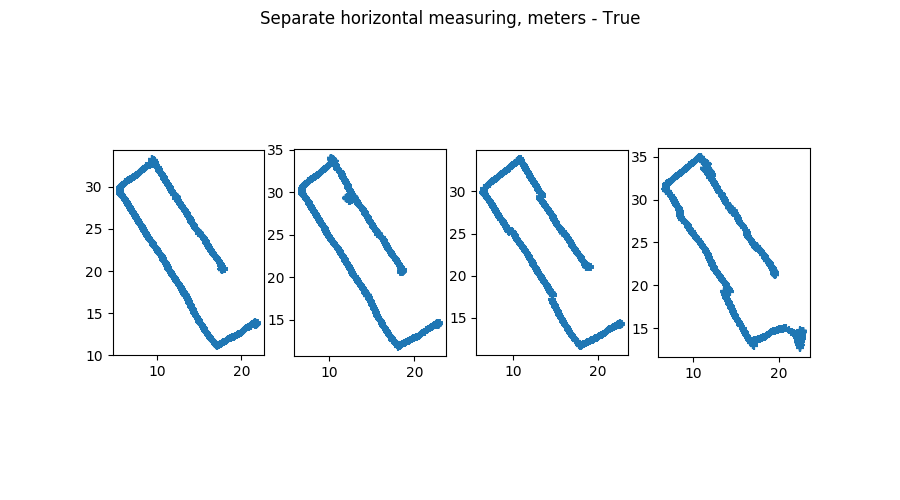

In [2]:
plots = tuple()
plotter.separate_h()

<IPython.core.display.Javascript object>


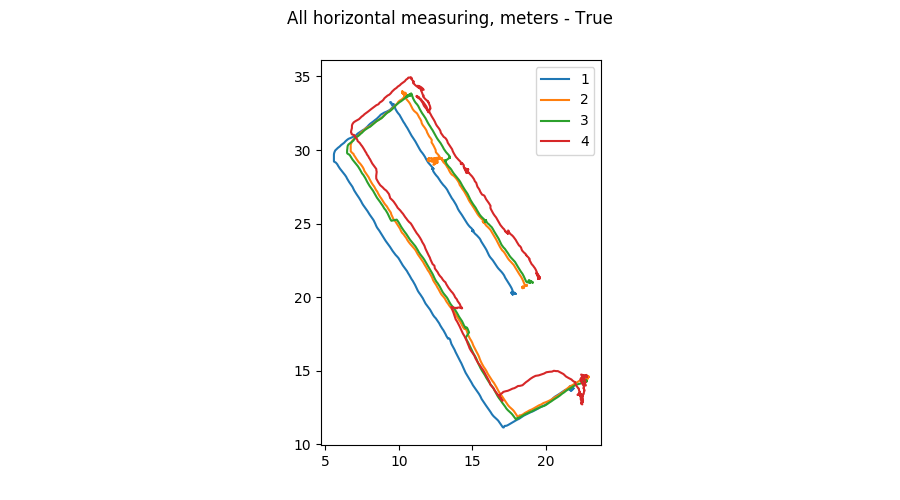

In [3]:
plotter.together_h(plots)

<IPython.core.display.Javascript object>


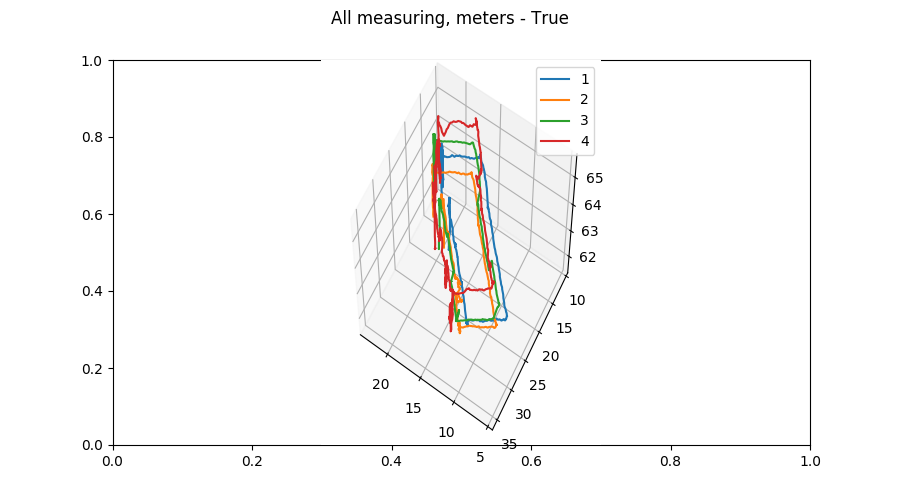

/home/tuuzdu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


In [4]:
plotter.together_3d(plots)

<IPython.core.display.Javascript object>


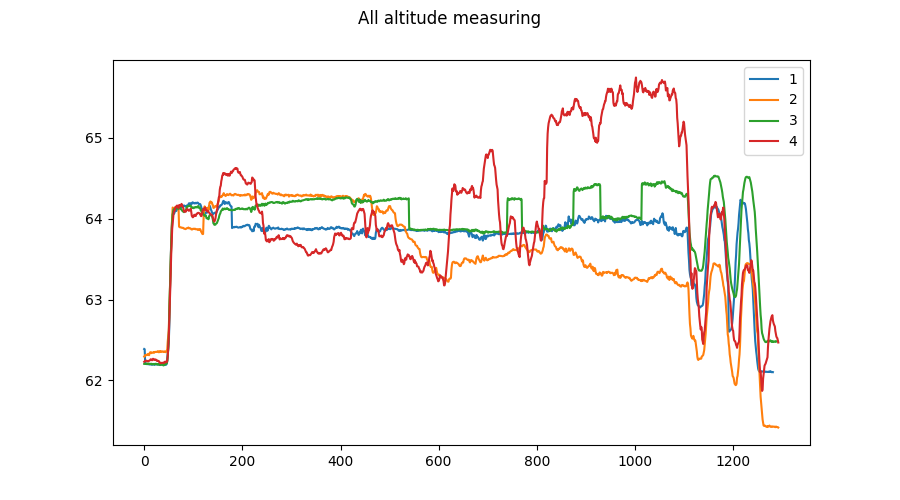

In [5]:
plotter.together_v(plots)

<IPython.core.display.Javascript object>


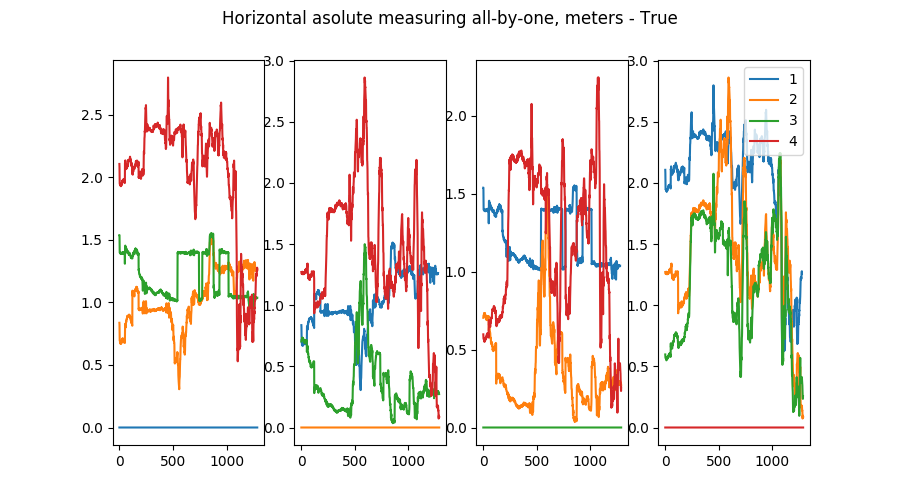

In [6]:
plotter.length_abs(plots)


Std dev relative:
['lat', 'lon', 'alt']


<IPython.core.display.Javascript object>


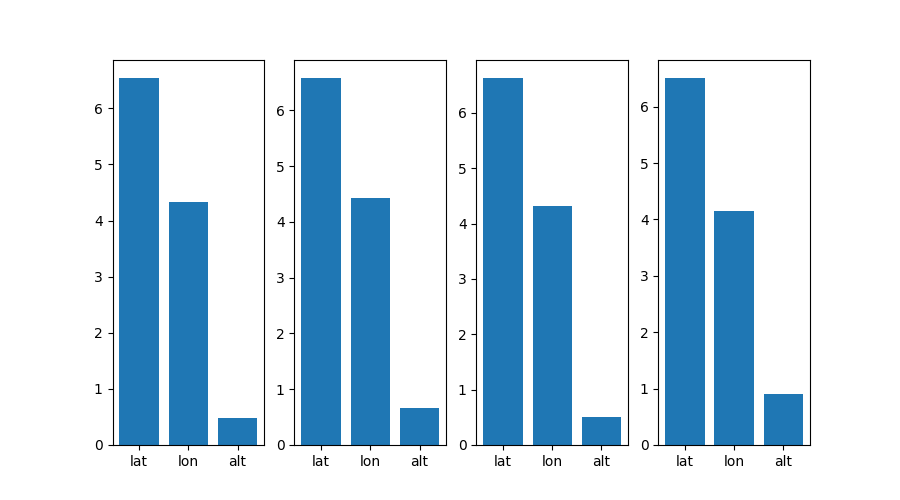

[6.53445382 4.32970715 0.4816883 ]
[6.57218974 4.43508957 0.67084877]
[6.62386534 4.31576746 0.50647141]
[6.50381497 4.15204896 0.9003989 ]


In [7]:
plotter.stddev_rel()

<IPython.core.display.Javascript object>


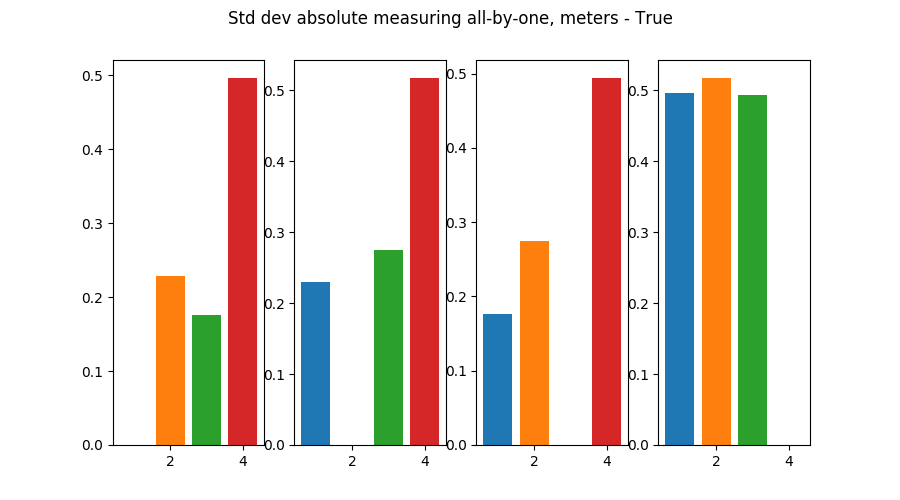


Std dev absolute between 0 and 0:
0.0

Std dev absolute between 0 and 1:
0.2289526279795026

Std dev absolute between 0 and 2:
0.1759008221350586

Std dev absolute between 0 and 3:
0.4961460544733781

Std dev absolute between 1 and 0:
0.2289526279795026

Std dev absolute between 1 and 1:
0.0

Std dev absolute between 1 and 2:
0.27449934056702746

Std dev absolute between 1 and 3:
0.5164868420750601

Std dev absolute between 2 and 0:
0.1759008221350586

Std dev absolute between 2 and 1:
0.27449934056702746

Std dev absolute between 2 and 2:
0.0

Std dev absolute between 2 and 3:
0.49356593641109037

Std dev absolute between 3 and 0:
0.4961460544733781

Std dev absolute between 3 and 1:
0.5164868420750601

Std dev absolute between 3 and 2:
0.49356593641109037

Std dev absolute between 3 and 3:
0.0


In [8]:
plotter.stddev_abs()